# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.


Исследование будет содержать следующие этапы:
- Загрузка и подготовка данных;
- Подготовка данных для обучения моделей;
- Обучения моделей;
- Анализ моделей;
- Проверка лучшей модели не тестовой выборке;
- Проверка лучшей модели на адекватность;
- Финальный вывод.

In [1]:
#! pip install lightgbm

In [2]:
#! pip install category_encoders

In [3]:
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import category_encoders as ce

In [4]:
warnings.filterwarnings("ignore")

## Загрузка и подготовка данных

In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('datasets/autos.csv')

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [9]:
df.columns.str.replace(r"([A-Z])", r" \1").str.lower()

Index([' date crawled', ' price', ' vehicle type', ' registration year',
       ' gearbox', ' power', ' model', ' kilometer', ' registration month',
       ' fuel type', ' brand', ' repaired', ' date created',
       ' number of pictures', ' postal code', ' last seen'],
      dtype='object')

In [10]:
df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_')

Index(['_date_crawled', '_price', '_vehicle_type', '_registration_year',
       '_gearbox', '_power', '_model', '_kilometer', '_registration_month',
       '_fuel_type', '_brand', '_repaired', '_date_created',
       '_number_of_pictures', '_postal_code', '_last_seen'],
      dtype='object')

In [11]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [12]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [13]:
len_original = len(df)

In [14]:
def get_missing_values(df): #Возвращает таблицу с количеством и долей пропусков в датафрейме
    data = (
        df.isna()
        .sum()
        .rename("missing_count")
        .to_frame()
        .join(df.isna().mean().rename("missing_ratio").to_frame())
        .sort_values(by="missing_count", ascending=False)
        # Удаляем данные о столбцах, где количество пропусков равняется 0
        .loc[lambda x: x["missing_count"] > 0]
    )
    return data

In [15]:
get_missing_values(df)

,missing_count,missing_ratio
repaired,71154,0.200791
vehicle_type,37490,0.105794
fuel_type,32895,0.092827
gearbox,19833,0.055967
model,19705,0.055606


Пропуски по ремонту автомобилей заполним значениями `no info`.
По остальным признакам попробуем восстановить данные, где это возможно.

In [16]:
df['repaired'] = df['repaired'].fillna('no info')

In [17]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,no info,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no info,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [18]:
# Заполним пропуске в признаке `model` значениями `no info`.
df['model'] = df['model'].fillna('no info')

In [19]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [20]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

In [21]:
df['fuel_type'].value_counts()

petrol      315072
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [22]:
%%time
# Данные по типу автомобиля, типу топлива, коробке передач заменим на наиболее частые в связке Brand-Model
for b in df['brand'].dropna().unique():
    for m in df[df['brand']==b]['model'].dropna().unique():
        df.loc[(df['brand'] == b) & (df['model'] == m) & (df['vehicle_type'].isna()), 'vehicle_type'] = \
        df.loc[(df['brand'] == b) & (df['model'] == m), 'vehicle_type'].mode()[0]
        
        df.loc[(df['brand'] == b) & (df['model'] == m) & (df['fuel_type'].isna()), 'fuel_type'] = \
        df.loc[(df['brand'] == b) & (df['model'] == m), 'fuel_type'].mode()[0]
        
        df.loc[(df['brand'] == b) & (df['model'] == m) & (df['gearbox'].isna()), 'gearbox'] = \
        df.loc[(df['brand'] == b) & (df['model'] == m), 'gearbox'].mode()[0]

CPU times: user 1min 42s, sys: 66.9 ms, total: 1min 42s
Wall time: 1min 42s


In [23]:
get_missing_values(df)

,missing_count,missing_ratio


Есть вероятность того, что объявления извлекались в разные года, то возраст автомобиля правильно оценивать на момент извлечения объявления. Проверим это.

In [24]:
display(df.sort_values('date_crawled').head(2))
display(df.sort_values('date_crawled', ascending=False).head(2))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
329497,2016-03-05 14:06:22,150,small,1997,manual,75,polo,150000,4,petrol,volkswagen,no,2016-03-05 00:00:00,0,35789,2016-03-27 17:16:15
220583,2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05 00:00:00,0,57080,2016-03-06 18:29:35


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
90713,2016-04-07 14:36:58,3500,sedan,1999,manual,143,e_klasse,150000,8,petrol,mercedes_benz,no,2016-04-07 00:00:00,0,64846,2016-04-07 14:36:58
339649,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56


Объекты были извлечены в течение одного месяца (32 дня), в этом случае столбец `date_crawled` не принесёт нам пользы, удалим его.

In [25]:
display(df.sort_values('last_seen').head(2))
display(df.sort_values('last_seen', ascending=False).head(2))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
296785,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,2016-03-05 00:00:00,0,65232,2016-03-05 14:15:08
262341,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2016-03-04 00:00:00,0,61348,2016-03-05 14:15:16


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
327303,2016-03-24 18:55:33,600,sedan,1997,manual,75,golf,150000,3,petrol,volkswagen,no,2016-03-24 00:00:00,0,59872,2016-04-07 14:58:51
68870,2016-03-21 16:06:19,11200,convertible,2002,auto,231,3er,125000,1,petrol,bmw,no,2016-03-21 00:00:00,0,55425,2016-04-07 14:58:50


Аналогично поступим с `last_seen` и `date_created`. Также удалим столбцы `registration_month`, `number_of_pictures` и `postal_code`.

In [26]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'registration_month', 'number_of_pictures', 'postal_code'], axis=1)

In [27]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no info
1,18300,coupe,2011,manual,190,no info,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [28]:
#Перенёс проверку на дубликаты после удаления неинформативных колонок.
df.shape

(354369, 10)

In [29]:
df.duplicated().sum()

50508

In [30]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [31]:
df.duplicated().sum()

0

In [32]:
numerical = ['price', 'registration_year', 'power', 'kilometer']
categorical = list(df.columns.difference(numerical))

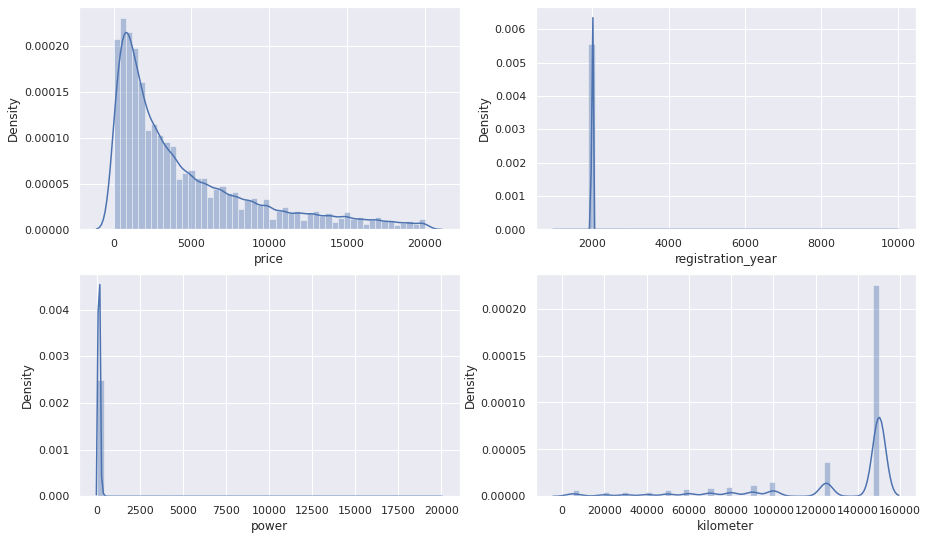

In [33]:
_, axes = plt.subplots(2, 2, figsize=(15, 9))
for i, n in enumerate(numerical):
    x,y = divmod(i,2)
    sns.distplot(df[n], ax=axes[x,y])

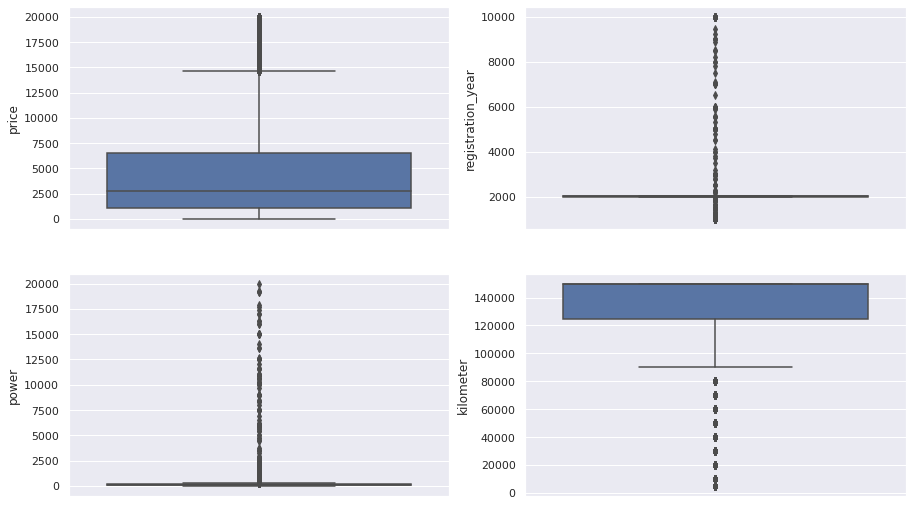

In [34]:
_, axes = plt.subplots(2, 2, figsize=(15, 9))
for i, n in enumerate(numerical):
    x,y = divmod(i,2)
    sns.boxplot(y=n, data=df, ax=axes[x,y])

Необходимо будет поработать с аномалиями/аутлаерами в данных.

In [35]:
print('Доля объектов среди исходного набора данных, мощность двигателя которых не меенее порогового значения:')
for i in range(300, 1000, 100):
    print(f'{i} л.с. составляет {df[df["power"]>=i]["power"].count()/len_original:.2%}')

Доля объектов среди исходного набора данных, мощность двигателя которых не меенее порогового значения:
300 л.с. составляет 0.97%
400 л.с. составляет 0.21%
500 л.с. составляет 0.14%
600 л.с. составляет 0.11%
700 л.с. составляет 0.10%
800 л.с. составляет 0.09%
900 л.с. составляет 0.09%


In [36]:
print('Доля объектов среди исходного набора данных, мощность двигателя которых не более порогового значения:')
for i in range(0, 101, 10):
    print(f'{i:3} л.с. составляет {df[df["power"]<=i]["power"].count()/len_original:6.2%} данных')

Доля объектов среди исходного набора данных, мощность двигателя которых не более порогового значения:
  0 л.с. составляет  9.71% данных
 10 л.с. составляет  9.77% данных
 20 л.с. составляет  9.83% данных
 30 л.с. составляет  9.96% данных
 40 л.с. составляет 10.18% данных
 50 л.с. составляет 12.15% данных
 60 л.с. составляет 18.64% данных
 70 л.с. составляет 22.01% данных
 80 л.с. составляет 29.51% данных
 90 л.с. составляет 35.06% данных
100 л.с. составляет 37.08% данных


In [37]:
power = 700

In [38]:
(df[df['power']>=power].groupby(['brand', 'model'])['model']
                    .count()
                    .sort_values(ascending=False)
                    .to_frame()
)

,,model
brand,model,
volkswagen,golf,20
bmw,3er,15
opel,astra,13
volkswagen,passat,12
opel,corsa,12
...,...,...
mercedes_benz,s_klasse,1
mazda,6_reihe,1
lancia,ypsilon,1


Golf, Corsa, Astra, Polo и другие модели вряд ли могут иметь мощность двигателя более 700 л.с.

In [39]:
(df[(df['power']>=power)&(~df['brand'].isin(['bmw','mercedes_benz']))].groupby(['brand', 'model'])['model']
                                                                      .count()
                                                                      .sort_values(ascending=False)
                                                                      .to_frame()
)

model
brand      model         
volkswagen golf        20
opel       astra       13
           vectra      12
volkswagen polo        12
           passat      12
...                   ...
mazda      6_reihe      1
lancia     ypsilon      1
           no info      1
kia        rio          1
nissan     x_trail      1

[108 rows x 1 columns]

In [40]:
(df[(df['power']>=power)&(~df['brand'].isin(['bmw','mercedes_benz']))].groupby(['registration_year'])['model']
                                                                      .count()
                                                                      .sort_values(ascending=False)
                                                                      .to_frame()
                                                                      .head()
)

,model
registration_year,
2000,24
2002,20
2001,19
1999,19
2017,17


In [41]:
# отфильтруем все объекты с мощностью (-ꝏ:50] & [700:ꝏ).
df = df[(df['power']<power)&(df['power']>50)]

Было удалено 12.25% исходных данных.

In [42]:
print('Доля объектов среди исходного набора данных, год регистрации которых не более порогового значения:')
for i in range(1926, 2026, 10):
    print(f'{i:4} г. составляет {df[df["registration_year"]<=i]["registration_year"].count()/len_original:6.2%} данных')

Доля объектов среди исходного набора данных, год регистрации которых не более порогового значения:
1926 г. составляет  0.00% данных
1936 г. составляет  0.00% данных
1946 г. составляет  0.01% данных
1956 г. составляет  0.02% данных
1966 г. составляет  0.08% данных
1976 г. составляет  0.30% данных
1986 г. составляет  0.97% данных
1996 г. составляет  8.71% данных
2006 г. составляет 49.53% данных
2016 г. составляет 70.83% данных


In [43]:
# Удалим все объекты, год регистрации которых не менее 1986 г. или более 2016 г. (год извлечения объявлений).
df = df[(df['registration_year']>1986)&(df['registration_year']<=2016)]

In [44]:
print('Доля объектов среди исходного набора данных, стоимость которых не более порогового значения:')
for i in range(0, 501, 25):
    print(f'{i:4} евро составляет {df[df["price"]<=i]["price"].count()/len_original:6.2%} данных')

Доля объектов среди исходного набора данных, стоимость которых не более порогового значения:
   0 евро составляет  1.35% данных
  25 евро составляет  1.52% данных
  50 евро составляет  1.56% данных
  75 евро составляет  1.58% данных
 100 евро составляет  1.74% данных
 125 евро составляет  1.79% данных
 150 евро составляет  2.03% данных
 175 евро составляет  2.07% данных
 200 евро составляет  2.45% данных
 225 евро составляет  2.50% данных
 250 евро составляет  2.85% данных
 275 евро составляет  2.89% данных
 300 евро составляет  3.42% данных
 325 евро составляет  3.45% данных
 350 евро составляет  3.89% данных
 375 евро составляет  3.92% данных
 400 евро составляет  4.46% данных
 425 евро составляет  4.48% данных
 450 евро составляет  4.84% данных
 475 евро составляет  4.86% данных
 500 евро составляет  5.95% данных


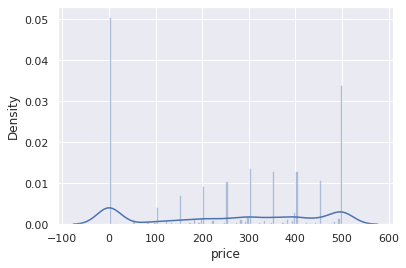

In [45]:
 sns.distplot(df[df['price']<=500]['price'], bins=100);

In [46]:
# Удалим все данные стоимостью 0 евро
df = df[df['price']>0]

Было удалено 1.35% исходного датасета.

In [47]:
print(f'В общей сложности мы удалили {(len_original - len(df))/len_original:6.2%} исходного датасета на этапе предобработки данных.')

В общей сложности мы удалили 31.49% исходного датасета на этапе предобработки данных.


**Вывод**

На этапе предобработки данных:
- Пропуски в признаке `model` заполнены как `no info`;
- Пропуски в признаке `repaired` заполнены как `no info`;
- Пропуски в признаках `vehicle_type`, `fuel_type` и `gearbox` были заполнены наиболее часто встречающимися значениями связки `brand` + `model`;
- Удалены признаки `date_crawled`, `date_created`, `last_seen`, `registration_month`, `number_of_pictures`, `postal_code`;
- Удалены объекты мощность которых менее 50 л.с. и более 700 л.с.;
- Удалены объекты год регистрации которых не более 1986 и более 2016;
- Удалены объекты с нулевой стоимостью.

Итого было удалено 31.49% исходного датасета.

## Подготовка данных для обучения моделей

In [48]:
RANDOM_STATE = 11363
RANDOM_SEED = RANDOM_STATE

In [49]:
X = df.drop('price', axis=1).columns
y = ['price']

In [50]:
numerical.remove(y[0])

In [51]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [52]:
df_copy = df.copy()
df_copy['model'] = calc_smooth_mean(df_copy, by='model', on='price', m=300)

In [53]:
df_copy.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,3605.084720,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,5995.244893,125000,petrol,jeep,no info
3,1500,small,2001,manual,75,4854.155567,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,4465.239067,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,5515.387490,150000,petrol,bmw,yes


In [54]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
print(f'Размер обучающей выборки {train.shape[0]}, это составляет {train.shape[0]/len(df):.2%} данных')
print(f'Размер тестовой выборки {test.shape[0]}, это составляет {test.shape[0]/len(df):.2%} данных')

Размер обучающей выборки 194233, это составляет 80.00% данных
Размер тестовой выборки 48559, это составляет 20.00% данных


In [55]:
train.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
52608,9900,sedan,2010,manual,105,a1,150000,petrol,audi,no
53232,3800,small,2000,manual,260,a3,150000,petrol,audi,no
151534,20000,sedan,2013,manual,220,golf,80000,petrol,volkswagen,no
109623,1700,convertible,1998,manual,90,megane,150000,petrol,renault,no
257257,7999,bus,2010,manual,101,c_max,80000,petrol,ford,no


In [56]:
# Посмотрим на разницzу в уникальных значениях `model` в train и test
set(test['model'].unique()) - set(train['model'].unique())

set()

Отлично, в тестовых данных отсутствуют уникальные модели в сравнении с тренировочными. Будем применять target encoding для признака `model`.

In [57]:
categorical.remove('model')
numerical.append('model')

In [58]:
ohe_list = categorical

In [59]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [60]:
encoder = OneHotEncoder(handle_unknown='ignore')#, drop='first') #удаляем первый столбец чтобы не попасть в дамми-ловушку

train_ohe = (pd.DataFrame(
     encoder.fit_transform(train[ohe_list]).toarray(),
     columns=encoder.get_feature_names(), #_out(),
     index=train.index)
     .join([train[y], train[numerical]], how='left')
)

test_ohe = (pd.DataFrame(
    encoder.transform(test[ohe_list]).toarray(),
    columns=encoder.get_feature_names(), #_out(),
    index=test.index)
    .join([test[y], test[numerical]], how='left')
)

In [61]:
train_ohe.head()

,x0_alfa_romeo,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,...,x4_other,x4_sedan,x4_small,x4_suv,x4_wagon,price,registration_year,power,kilometer,model
52608,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,9900,2010,105,150000,a1
53232,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,3800,2000,260,150000,a3
151534,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,20000,2013,220,80000,golf
109623,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1700,1998,90,150000,megane
257257,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,7999,2010,101,80000,c_max


In [62]:
test_ohe.head()

,x0_alfa_romeo,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,...,x4_other,x4_sedan,x4_small,x4_suv,x4_wagon,price,registration_year,power,kilometer,model
181974,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,3300,2001,115,150000,no info
174068,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,14200,2006,231,125000,e_klasse
254003,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,199,2000,113,150000,colt
183861,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,12300,2004,333,150000,7er
154277,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1480,1997,125,150000,passat


In [63]:
display(train.head())
display(test.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
52608,9900,sedan,2010,manual,105,a1,150000,petrol,audi,no
53232,3800,small,2000,manual,260,a3,150000,petrol,audi,no
151534,20000,sedan,2013,manual,220,golf,80000,petrol,volkswagen,no
109623,1700,convertible,1998,manual,90,megane,150000,petrol,renault,no
257257,7999,bus,2010,manual,101,c_max,80000,petrol,ford,no


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
181974,3300,convertible,2001,manual,115,no info,150000,petrol,volkswagen,no info
174068,14200,sedan,2006,auto,231,e_klasse,125000,petrol,mercedes_benz,no
254003,199,sedan,2000,manual,113,colt,150000,petrol,mitsubishi,no info
183861,12300,sedan,2004,auto,333,7er,150000,lpg,bmw,no
154277,1480,sedan,1997,manual,125,passat,150000,petrol,volkswagen,no


In [64]:
X_ohe = list(train_ohe.columns)
X_ohe.remove('price')

In [65]:
# Initialize and fit target encoder
target_encoder = ce.TargetEncoder(cols=['model'])
target_encoder.fit(train_ohe['model'], train_ohe[y])

# Transform training and test data
train_ohe['model'] = target_encoder.transform(train_ohe['model'])
test_ohe['model'] = target_encoder.transform(test_ohe['model'])

# Check results
print(train_ohe['model'].head())
print(test_ohe['model'].head())


52608    13980.74
53232     6666.54
151534    4863.84
109623    3426.28
257257    6336.99
Name: model, dtype: float64
181974   3548.15
174068   6062.39
254003   2493.93
183861   6438.96
154277   4881.24
Name: model, dtype: float64


In [66]:
scaler = StandardScaler()
scaler.fit(train_ohe[numerical])
train_ohe[numerical] = scaler.transform(train_ohe[numerical])
test_ohe[numerical] = scaler.transform(test_ohe[numerical]);

In [67]:
train_ohe.head()

,x0_alfa_romeo,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,...,x4_other,x4_sedan,x4_small,x4_suv,x4_wagon,price,registration_year,power,kilometer,model
52608,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,9900,1.15,-0.36,0.61,3.67
53232,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,3800,-0.60,2.55,0.61,0.67
151534,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,20000,1.68,1.80,-1.28,-0.07
109623,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1700,-0.95,-0.64,0.61,-0.66
257257,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,7999,1.15,-0.44,-1.28,0.53


In [68]:
test_ohe.head()

,x0_alfa_romeo,x0_audi,x0_bmw,x0_chevrolet,x0_chrysler,x0_citroen,x0_dacia,x0_daewoo,x0_daihatsu,x0_fiat,...,x4_other,x4_sedan,x4_small,x4_suv,x4_wagon,price,registration_year,power,kilometer,model
181974,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,3300,-0.43,-0.17,0.61,-0.61
174068,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,14200,0.45,2.00,-0.07,0.42
254003,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,199,-0.60,-0.21,0.61,-1.05
183861,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,12300,0.10,3.92,0.61,0.57
154277,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1480,-1.13,0.01,0.61,-0.07


**Вывод**

Было осуществлено масштабирование численных признаков, а также выполнено кодирование переменных.

## Обучение моделей

### CatBoost

In [69]:
categorical.append('model')

In [70]:
cat_features = categorical

params = {'cat_features': cat_features,
          'loss_function': 'RMSE',
          'random_seed': RANDOM_SEED,
          'verbose': 100,
          'early_stopping_rounds': 100}

In [71]:
start_time = time.time()

model = CatBoostRegressor(**params)

param_grid_cb = {'depth': [8],
                 'l2_leaf_reg': [3],
                 'learning_rate': [0.3],
                }
gs_cb = GridSearchCV(estimator = model, param_grid = param_grid_cb, cv = 3, scoring='neg_root_mean_squared_error')
gs_cb.fit(train[X], train[y])

end_time = time.time()
elapsed_time_cb = 9655.06 # захардкодил время (считалось по 60 фолдам в сумме) и сократил параметры, дабы не ждать 2 часа.

best_cb = gs_cb.best_params_

0:	learn: 3722.4807609	total: 304ms	remaining: 5m 3s
100:	learn: 1562.9081543	total: 16.7s	remaining: 2m 29s
200:	learn: 1490.4542792	total: 33.2s	remaining: 2m 12s
300:	learn: 1443.9912577	total: 50.1s	remaining: 1m 56s
400:	learn: 1410.5337346	total: 1m 6s	remaining: 1m 39s
500:	learn: 1383.0427154	total: 1m 23s	remaining: 1m 23s
600:	learn: 1360.9409267	total: 1m 39s	remaining: 1m 6s
700:	learn: 1342.5829181	total: 1m 56s	remaining: 49.8s
800:	learn: 1326.2846149	total: 2m 13s	remaining: 33.1s
900:	learn: 1311.4402692	total: 2m 29s	remaining: 16.5s
999:	learn: 1297.0826716	total: 2m 46s	remaining: 0us
0:	learn: 3723.6247236	total: 214ms	remaining: 3m 33s
100:	learn: 1562.5288265	total: 16.2s	remaining: 2m 24s
200:	learn: 1486.9892603	total: 32.6s	remaining: 2m 9s
300:	learn: 1442.0016235	total: 49.3s	remaining: 1m 54s
400:	learn: 1410.9422129	total: 1m 6s	remaining: 1m 39s
500:	learn: 1384.7476862	total: 1m 23s	remaining: 1m 23s
600:	learn: 1364.4659371	total: 1m 40s	remaining: 1m 7

In [72]:
predict = gs_cb.predict(train[X])
score_cb = -gs_cb.best_score_
score_2_cb = mean_squared_error(train[y], predict)**0.5

In [73]:
print(f'Лучшие параметры = {best_cb}')
print(f'RMSE модели на кросс валидации после подбора гиперпараметров = {score_cb:.2f}')
print(f'RMSE по предикту = {score_2_cb:.2f}')
print(f'Поиск оптимальных гиперпараметров занимает {elapsed_time_cb:.2f} секунд.')

Лучшие параметры = {'depth': 8, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
RMSE модели на кросс валидации после подбора гиперпараметров = 1584.29
RMSE по предикту = 1390.97
Поиск оптимальных гиперпараметров занимает 9655.06 секунд.


In [74]:
model = CatBoostRegressor(**best_cb)

In [75]:
start_time = time.time()
model.fit(train[X], train[y], verbose=100, cat_features=cat_features)
end_time = time.time()

train_time = end_time - start_time

start_time = time.time()
pred = model.predict(train[X])
end_time = time.time()
predict_time = end_time - start_time 

0:	learn: 3734.3507364	total: 332ms	remaining: 5m 32s
100:	learn: 1561.4449577	total: 22.4s	remaining: 3m 18s
200:	learn: 1497.4642515	total: 45.6s	remaining: 3m 1s
300:	learn: 1459.6772305	total: 1m 8s	remaining: 2m 40s
400:	learn: 1431.2212407	total: 1m 32s	remaining: 2m 17s
500:	learn: 1411.0921274	total: 1m 54s	remaining: 1m 54s
600:	learn: 1392.1745421	total: 2m 17s	remaining: 1m 31s
700:	learn: 1375.8161356	total: 2m 41s	remaining: 1m 8s
800:	learn: 1361.2248085	total: 3m 4s	remaining: 45.8s
900:	learn: 1349.2908336	total: 3m 28s	remaining: 22.9s
999:	learn: 1338.2211187	total: 3m 52s	remaining: 0us


In [76]:
results = pd.DataFrame(index = ['RMSE', 'train_time_sec', 'predict_time_sec', 'parameters_tuning_time_sec'])
results['1_CatBoost'] = [score_cb, train_time, predict_time, elapsed_time_cb]
results

,1_CatBoost
RMSE,1584.29
train_time_sec,236.51
predict_time_sec,3.21
parameters_tuning_time_sec,9655.06


### LightGBM

In [77]:
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [80]:
param_grid_lgbm = {'learning_rate':[0.3], 'n_estimators':[200], 'max_depth':[10]}
gs_lgbm = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE, verbose=0),
                       param_grid=param_grid_lgbm,
                       cv=3,
                       scoring='neg_root_mean_squared_error'
                      )

start_time=time.time()
gs_lgbm.fit(train[X], train[y])
end_time=time.time()
elapsed_time_lgbm = end_time - start_time
best_lgbm = gs_lgbm.best_params_
score_lgbm = -gs_lgbm.best_score_
score_2_lgbm = mean_squared_error(train[y], gs_lgbm.predict(train[X]))**0.5

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.379550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR

In [81]:
model=LGBMRegressor(**best_lgbm)

start_time = time.time()
model.fit(train[X], train[y])
end_time = time.time()

train_time = end_time - start_time

start_time = time.time()
predict = model.predict(train[X])
end_time = time.time()

predict_time = end_time - start_time

In [82]:
print(f'Лучшие параметры = {best_lgbm}')
print(f'RMSE модели на кросс валидации после подбора гиперпараметров = {score_lgbm:.2f}')
print(f'Поиск оптимальных гиперпараметров занимает {elapsed_time_lgbm:.2f} секунд.')

Лучшие параметры = {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200}
RMSE модели на кросс валидации после подбора гиперпараметров = 1593.60
Поиск оптимальных гиперпараметров занимает 842.28 секунд.


In [83]:
results['2_LightGBM'] = [score_lgbm, train_time, predict_time, elapsed_time_lgbm]
results

,1_CatBoost,2_LightGBM
RMSE,1584.29,1593.60
train_time_sec,236.51,74.78
predict_time_sec,3.21,2.43
parameters_tuning_time_sec,9655.06,842.28


###  RandomForest

In [84]:
model = RandomForestRegressor(random_state=RANDOM_STATE, verbose=1)

In [85]:
param_rf = {'n_estimators':[100], 'max_depth':[8]}
gs_rf = GridSearchCV(estimator=model,
                     param_grid=param_rf,
                     cv=3,
                     scoring='neg_root_mean_squared_error')

start_time=time.time()
gs_rf.fit(train_ohe[X_ohe], train_ohe[y])
end_time=time.time()
elapsed_time_rf = end_time - start_time
best_rf = gs_rf.best_params_
score_rf = - gs_rf.best_score_
score_2_rf = mean_squared_error(train_ohe[y], gs_rf.predict(train_ohe[X_ohe]))**0.5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   37.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   37.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [86]:
model=RandomForestRegressor(**best_rf)

start_time = time.time()
model.fit(train_ohe[X_ohe], train_ohe[y])
end_time = time.time()

train_time = end_time - start_time

start_time = time.time()
predict = model.predict(train_ohe[X_ohe])
end_time = time.time()

predict_time = end_time - start_time

In [87]:
print(f'Лучшие параметры = {best_rf}')
print(f'RMSE модели на кросс валидации после подбора гиперпараметров = {score_rf:.2f}')
print(f'Поиск оптимальных гиперпараметров занимает {elapsed_time_rf:.2f} секунд.')

Лучшие параметры = {'max_depth': 8, 'n_estimators': 100}
RMSE модели на кросс валидации после подбора гиперпараметров = 1955.74
Поиск оптимальных гиперпараметров занимает 175.02 секунд.


In [88]:
results['3_RandomForest'] = [score_rf, train_time, predict_time, elapsed_time_rf]
results

,1_CatBoost,2_LightGBM,3_RandomForest
RMSE,1584.29,1593.60,1955.74
train_time_sec,236.51,74.78,61.98
predict_time_sec,3.21,2.43,1.39
parameters_tuning_time_sec,9655.06,842.28,175.02


**Вывод**

Был исследован результат работы 3-ёх моделей (CatBoost, LGMB, RandomForest), сохранены показатели RMSE, а также времени обучения и предсказания моделей.

## Анализ моделей

In [89]:
(results.T.style.format('{:.2f}', na_rep='-')
                .highlight_min(color='green')
                .highlight_max(color='red')
)

,RMSE,train_time_sec,predict_time_sec,parameters_tuning_time_sec
1_CatBoost,1584.29,236.51,3.21,9655.06
2_LightGBM,1593.60,74.78,2.43,842.28
3_RandomForest,1955.74,61.98,1.39,175.02


**Вывод**

Наилучшим качеством обладает модель CatBoost.
По скорости обучения и предсказания лучше себя показывает модель LightGBM.

С учётом незначительной разницы в скорости предсказания, рекомендуется использование модели CatBoost.
В случае, если необходимо учитывать и время на перебор гиперпараметров, рекомендуется использовать LightGBM.

## Проверка модели на тестовой выборке

In [90]:
model = CatBoostRegressor(**best_cb, random_seed=RANDOM_SEED, verbose=100)

In [91]:
model.fit(train[X], train[y], cat_features=cat_features)

0:	learn: 3721.9933691	total: 370ms	remaining: 6m 9s
100:	learn: 1567.9135524	total: 24.6s	remaining: 3m 39s
200:	learn: 1498.9944752	total: 49.8s	remaining: 3m 17s
300:	learn: 1460.2665635	total: 1m 14s	remaining: 2m 54s
400:	learn: 1431.3895160	total: 1m 40s	remaining: 2m 30s
500:	learn: 1409.3642138	total: 2m 6s	remaining: 2m 6s
600:	learn: 1390.8374737	total: 2m 32s	remaining: 1m 41s
700:	learn: 1375.0525628	total: 2m 58s	remaining: 1m 16s
800:	learn: 1360.5478919	total: 3m 23s	remaining: 50.6s
900:	learn: 1346.9574986	total: 3m 50s	remaining: 25.3s
999:	learn: 1334.5528664	total: 4m 16s	remaining: 0us


In [92]:
predict_test_cb = model.predict(test[X])
print(f'Модель {model}\nс параметрами {best_cb}\nна тестовой выборке показывает RMSE {mean_squared_error(test[y], predict_test_cb)**0.5:.2f}')

Модель <catboost.core.CatBoostRegressor object at 0x7f3295bb40a0>
с параметрами {'depth': 8, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
на тестовой выборке показывает RMSE 1560.28


In [94]:
model = LGBMRegressor(**best_lgbm)
model.fit(train[X], train[y])
predict_test_lgbm = model.predict(test[X])

In [95]:
model = RandomForestRegressor(**best_rf)
model.fit(train_ohe[X_ohe], train_ohe[y])
predict_test_rf = model.predict(test_ohe[X_ohe])

In [96]:
results_test = pd.DataFrame(index = ['RMSE_test'])
results_test['1_CatBost'] = [mean_squared_error(test[y], predict_test_cb)**0.5]
results_test['2_LGBM'] = [mean_squared_error(test_ohe[y], predict_test_lgbm)**0.5]
results_test['3_RandomForest'] = [mean_squared_error(test_ohe[y], predict_test_rf)**0.5]
results_test

,1_CatBost,2_LGBM,3_RandomForest
RMSE_test,1560.28,1570.00,1978.94


## Сравнение лучшей модели с dummy моделью(mean)

In [97]:
test['dummy_price'] = train['price'].mean()

In [98]:
print(f'RMSE dummy(mean) модели на тестовой выборке {mean_squared_error(test[y], test["dummy_price"])**0.5:.2f}')

RMSE dummy(mean) модели на тестовой выборке 4679.68


In [99]:
results_test['4_dummy(mean)'] = [mean_squared_error(test[y], test["dummy_price"])**0.5]
results_test

,1_CatBost,2_LGBM,3_RandomForest,4_dummy(mean)
RMSE_test,1560.28,1570.00,1978.94,4679.68


In [100]:
test = test.drop('dummy_price', axis=1)

## Финальный вывод

На этапе предобработки данных:
- Удалены объекты с пропусками в признаке `model`;
- Пропуски в признаке `repaired` заполнены как `no info`;
- Пропуски в признаках `vehicle_type`, `fuel_type` и `gearbox` были заполнены наиболее часто встречающимися значениями связки `brand` + `model`;
- Удалены признаки `date_crawled`, `date_created`, `last_seen`, `registration_month`, `number_of_pictures`, `postal_code`;
- Удалены полные дубликаты;
- Удалены объекты мощность которых менее 50 л.с. и более 700 л.с.;
- Удалены объекты год регистрации которых не более 1986 и более 2016;
- Удалены объекты с нулевой стоимостью.
Итого было удалено 18.33% исходного датасета.


На этапе подготовки данных для обучения моделей было осуществлено масштабирование численных признаков, а также кодирование категориальных.

На этапе обучения моделей был исследован результат работы 3-ёх моделей (CatBoost, LGMB, RandomForest), подобраны гиперпараметры, сохранены показатели качества моделей, а также времени обучения и предсказания.

На этапе анализа было предложено использование оптимальной модели - CatBoost.

На тестовой выборке RMSE модели = 1560.